# Based on Yann LeCun, 1998

- Incorpores preproceses and augmentation layers
- Changes Output layer

# Entorno de Ejecución


---



In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug 29 15:53:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.01              Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     On  | 00000000:01:00.0  On |                  N/A |
| N/A   35C    P8              N/A / ERR! |     90MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.3 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
import numpy as np
import os
# import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam


2023-08-29 15:53:36.847587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Creating dataset and model

In [4]:
img_train = '/tf/train'


traindataset = K.utils.image_dataset_from_directory(img_train,
                                                    label_mode='categorical',
#                                                     color_mode='grayscale',
                                                    batch_size=32,
                                                    image_size=(48,48),
                                                    seed=7,
                                                    )

img_test = '/tf/test'

testdataset = K.utils.image_dataset_from_directory(img_test,
                                                    label_mode='categorical',
#                                                     color_mode='grayscale',
                                                    batch_size=32,
                                                    image_size=(48,48),
                                                    seed=7,
                                                    )


Found 28709 files belonging to 7 classes.


2023-08-29 15:54:07.236673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 15:54:07.244165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 15:54:07.244586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 15:54:07.246678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 15:54:07.247117: I tensorflow/compile

Found 7178 files belonging to 7 classes.


In [7]:
model_path = '/tf/LeNet5.h5'

model = Sequential()

model.add(K.layers.experimental.preprocessing.Resizing(28, 28, input_shape=(48, 48, 3)))
model.add(K.layers.experimental.preprocessing.Rescaling(1./255))
model.add(K.layers.experimental.preprocessing.RandomFlip('horizontal', 0))
model.add(K.layers.experimental.preprocessing.RandomContrast([0.9, 1.1], 1))
model.add(K.layers.experimental.preprocessing.RandomRotation((-0.2, 0.3), seed=2))

model.add(Conv2D(6, (5, 5), padding='same', activation='sigmoid'))
model.add(K.layers.AveragePooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(6, (5, 5), activation='sigmoid'))
model.add(K.layers.AveragePooling2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(120, activation='sigmoid', kernel_initializer='he_normal'))
model.add(Dense(84, activation='sigmoid', kernel_initializer='he_normal'))

model.add(Dense(7, activation='softmax', kernel_initializer='he_normal'))


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 28, 28, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 28, 28, 3)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 28, 28, 3)         0         
                                                                 
 random_contrast_1 (RandomC  (None, 28, 28, 3)         0         
 ontrast)                                                        
                                                                 
 random_rotation_1 (RandomR  (None, 28, 28, 3)         0         
 otation)                                                        
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 6)        

In [8]:
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

best = [K.callbacks.ModelCheckpoint(model_path,
                                   save_best_only=True)
#        K.callbacks.LearningRateScheduler(scheduler)
#        K.callbacks.EarlyStopping(monitor='val_loss',
#                                 patience=5,
#                                 verbose=1)
       ]

history = model.fit(traindataset,
                    validation_data=testdataset,
                    epochs=20,
                    verbose=True,
                    callbacks=best)

Epoch 1/20
898/898 [==============================] - 35s 37ms/step - loss: 1.8239 - accuracy: 0.2513 - val_loss: 1.8146 - val_accuracy: 0.2471
Epoch 2/20
898/898 [==============================] - 33s 36ms/step - loss: 1.8103 - accuracy: 0.2513 - val_loss: 1.8138 - val_accuracy: 0.2471
Epoch 3/20
898/898 [==============================] - 33s 37ms/step - loss: 1.8084 - accuracy: 0.2513 - val_loss: 1.8102 - val_accuracy: 0.2471
Epoch 4/20
898/898 [==============================] - 34s 38ms/step - loss: 1.8020 - accuracy: 0.2517 - val_loss: 1.8005 - val_accuracy: 0.2474
Epoch 5/20
898/898 [==============================] - 33s 36ms/step - loss: 1.7921 - accuracy: 0.2544 - val_loss: 1.7926 - val_accuracy: 0.2506
Epoch 6/20
898/898 [==============================] - 33s 36ms/step - loss: 1.7873 - accuracy: 0.2564 - val_loss: 1.7887 - val_accuracy: 0.2498
Epoch 7/20
898/898 [==============================] - 33s 37ms/step - loss: 1.7853 - accuracy: 0.2556 - val_loss: 1.7873 - val_accuracy:

In [9]:
print(type(history.history))
print(history.history.keys())
largo = len(history.history['accuracy'])
largo

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


20

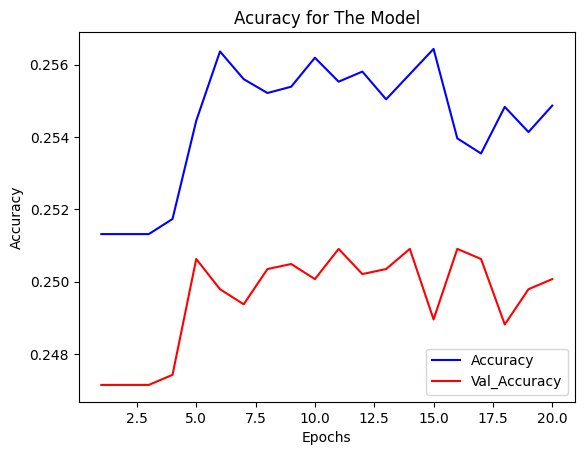

In [10]:
# Review Accuracy

plt.plot(range(1, largo + 1), history.history['accuracy'], '-b', label='Accuracy')
plt.plot(range(1, largo + 1), history.history['val_accuracy'], '-r', label='Val_Accuracy')
plt.title('Acuracy for The Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
eval = model.evaluate(testdataset, verbose=True, use_multiprocessing=True, return_dict=True)

225/225 [==============================] - 4s 19ms/step - loss: 1.7796 - accuracy: 0.2501


In [12]:
print(eval)

{'loss': 1.7796258926391602, 'accuracy': 0.25006964802742004}


In [13]:
prediction = model.predict(testdataset)

225/225 [==============================] - 4s 17ms/step


In [14]:
print(prediction)
print(prediction.shape)

[[0.13282429 0.01443767 0.11405068 ... 0.20080867 0.17025542 0.07602925]
 [0.12897402 0.01442437 0.13000505 ... 0.2149935  0.19075087 0.06239002]
 [0.12226    0.0216912  0.17527685 ... 0.1164747  0.09933276 0.20958422]
 ...
 [0.15404205 0.01243666 0.10578977 ... 0.21432513 0.22776657 0.03921979]
 [0.12605774 0.01603943 0.12213791 ... 0.19294003 0.1526134  0.09592483]
 [0.12949292 0.01635669 0.13152942 ... 0.1844812  0.15426655 0.09798578]]
(7178, 7)


In [15]:
names = {k: v for v, k in enumerate(testdataset.class_names)}
print(names)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [16]:
y_true = []
y_pred = []

for x, y in testdataset:
    predictions = model.predict(x)
    
    predicted_classes = np.argmax(predictions, axis=1)
    
    true_classes = np.argmax(y.numpy(), axis=1)
    
    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 83ms/step


In [ ]:
!pip install scikit-learn
!pip install seaborn

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

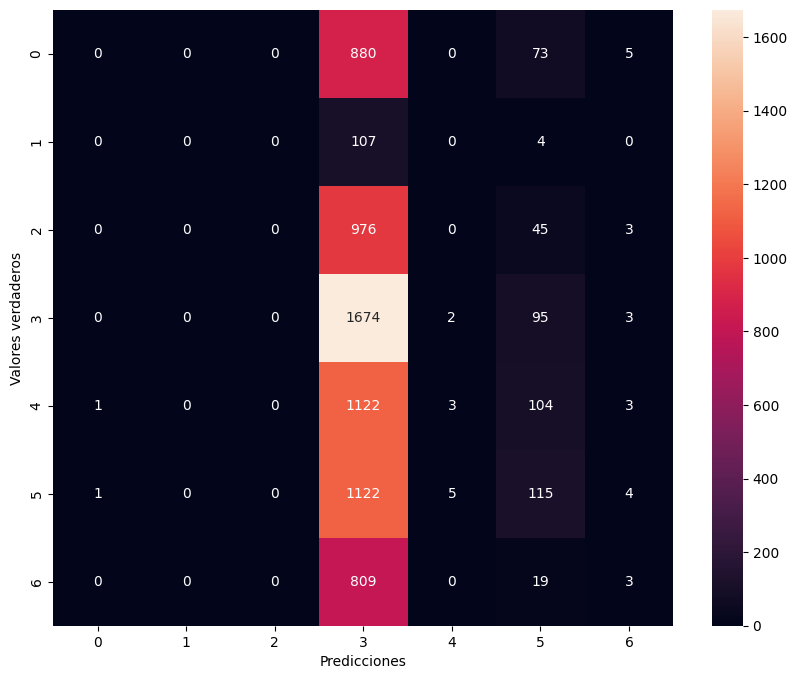

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.show()
